In [1]:
img_names = ["OneAxis/1.png", "OneAxis/2.png", "OneAxis/3.png"]
import cv2
from matplotlib import pyplot as plt 

def show_image(bgr):
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    plt.show()
    

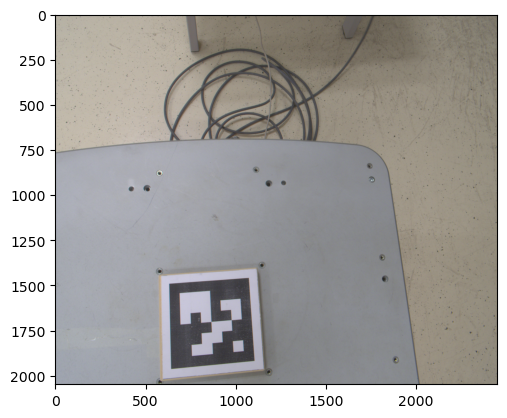

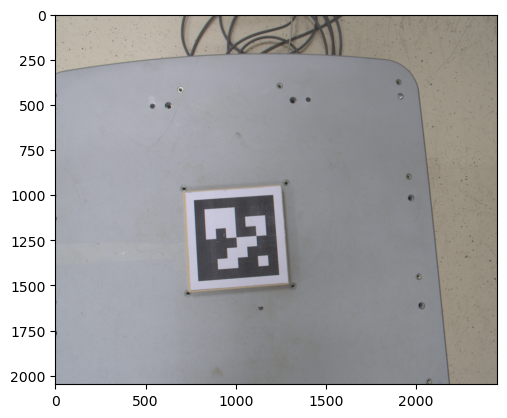

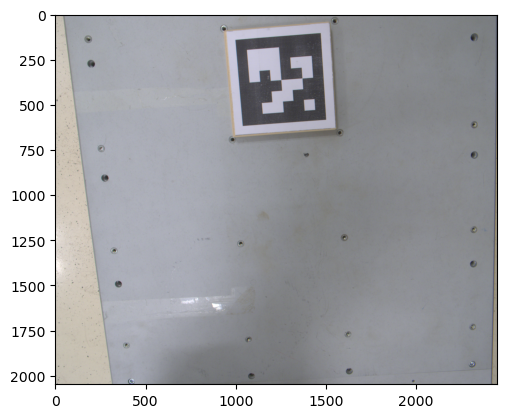

In [6]:
images = [cv2.imread(img_name) for img_name in img_names]
for img in images:
    show_image(img)

In [16]:
intrinsic_dict_path = "OneAxis/intrinsic.json"
import json
import numpy as np
with open(intrinsic_dict_path, "r") as f:
    intrinsic_dict = json.load(f)
# print(intrinsic_dict)
Kmx = np.array(intrinsic_dict["K"])
dist_coeff = np.array(intrinsic_dict["dist_coeff"])[0]
print(Kmx)
print(dist_coeff)

[[2.32941813e+03 0.00000000e+00 1.12927316e+03]
 [0.00000000e+00 2.32391333e+03 9.42049001e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[-0.07907305  0.12203021 -0.00445331 -0.01073551 -0.14396463]


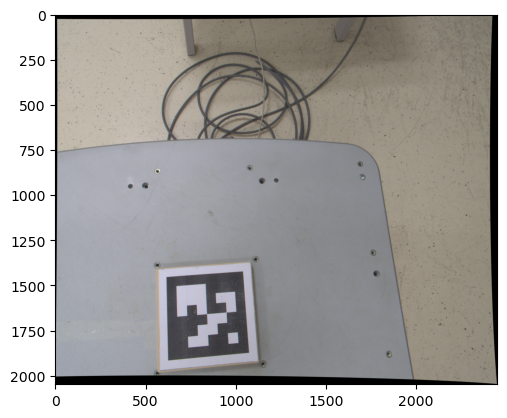

(2048, 2448, 3)
(13, 28, 2395, 1971)


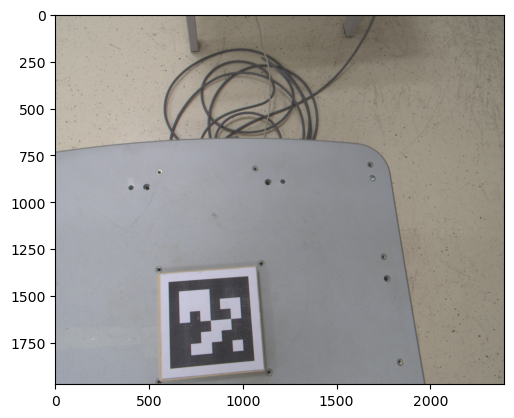

(1971, 2395, 3)
===


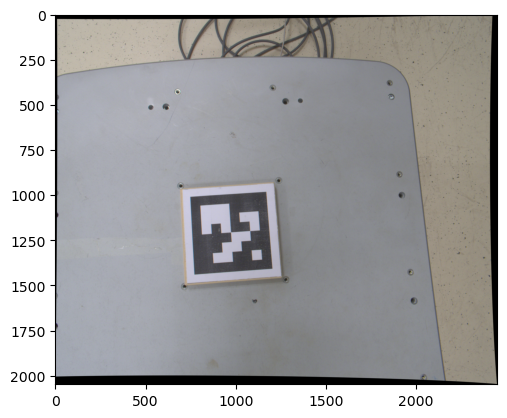

(2048, 2448, 3)
(13, 28, 2395, 1971)


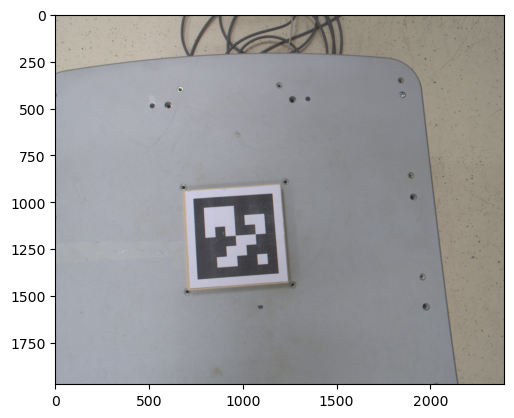

(1971, 2395, 3)
===


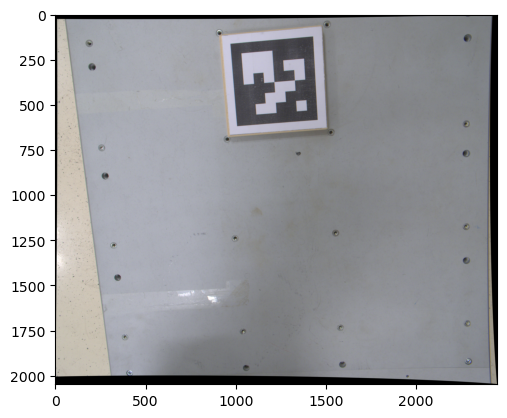

(2048, 2448, 3)
(13, 28, 2395, 1971)


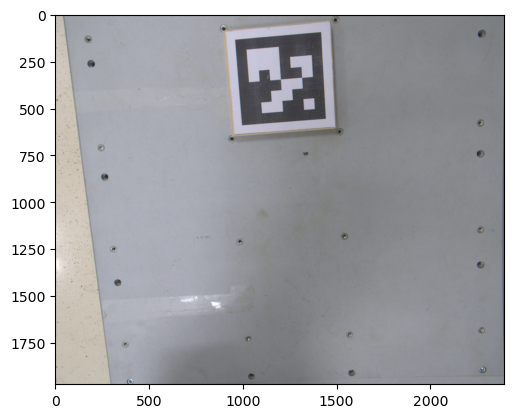

(1971, 2395, 3)
===


In [48]:
h, w = images[0].shape[:2]
Kmx_undistorted, roi = cv2.getOptimalNewCameraMatrix(Kmx, dist_coeff, (w,h), 1, (w,h))
dist_coeff_undistorted = np.array([0,0,0,0], dtype=np.float32)
undistorted_imgs = []
for img in images:
    undistorted = cv2.undistort(img, Kmx, dist_coeff, None, Kmx_undistorted)
    show_image(undistorted)
    print(undistorted.shape)
    print(roi)
    x, y, w, h = roi
    cropped = undistorted[y:y+h, x:x+w]
    show_image(cropped)
    print(cropped.shape)
    print("===")
    undistorted_imgs.append(cropped)

(array([[[ 614., 1889.],
        [ 604., 1428.],
        [1028., 1397.],
        [1061., 1846.]]], dtype=float32),)
[[0]]
[array([[ 2.01044607],
       [-2.16822672],
       [ 0.35719449]])]
[array([[-73.14040539],
       [196.09672745],
       [614.83004946]])]


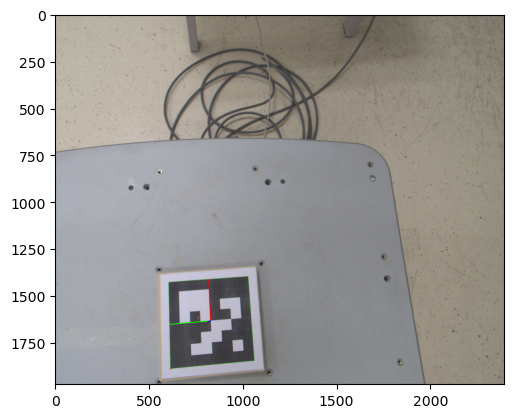

(array([[[ 759., 1414.],
        [ 736.,  984.],
        [1156.,  956.],
        [1190., 1381.]]], dtype=float32),)
[[0]]
[array([[ 2.09116733],
       [-2.24600723],
       [ 0.17125807]])]
[array([[-37.31274451],
       [ 71.82098158],
       [627.07218575]])]


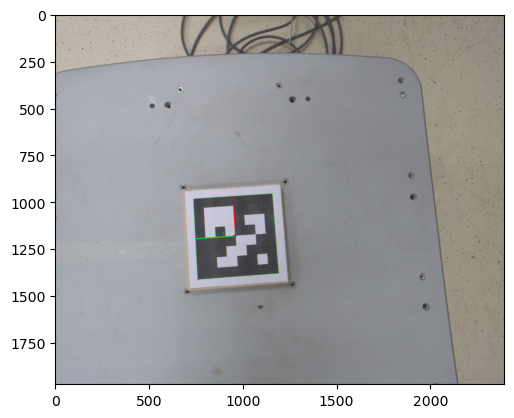

(array([[[ 996.,  592.],
        [ 959.,  136.],
        [1416.,   96.],
        [1441.,  558.]]], dtype=float32),)
[[0]]
[array([[-2.08571927],
       [ 2.24323812],
       [ 0.21302523]])]
[array([[  28.71832439],
       [-155.17270052],
       [ 593.82902705]])]


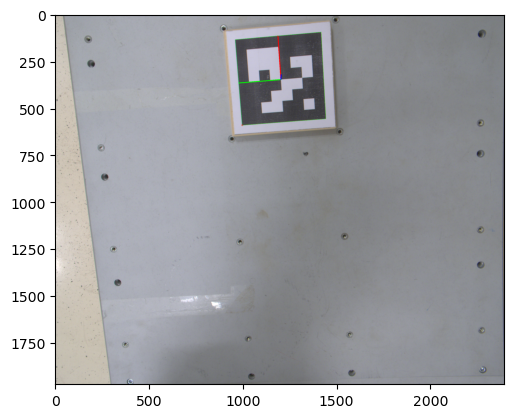

In [59]:
import cv2.aruco as aruco

# Load the dictionary that was used to generate the markers.
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)

# Initialize the detector parameters using default values
parameters = aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

marker_size = 120  # mm


def estimate_marker_pose(corners, K, dist_coeff, marker_size):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(marker_points, c, K, dist_coeff, False, cv2.SOLVEPNP_IPPE_SQUARE)
        rvecs.append(R)
        tvecs.append(t)
        trash.append(nada)
    return rvecs, tvecs, trash

import copy
imgs_to_process = copy.deepcopy(undistorted_imgs)
Rmx_target2cam = []
tv_target2cam = []
# Detect the markers in the image
for img in imgs_to_process:

    gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = detector.detectMarkers(gray)
    print(corners)
    print(ids)
   
    if ids is not None:
        # Estimate pose of each marker
        rvecs, tvecs, _ = estimate_marker_pose(corners, Kmx_undistorted, dist_coeff_undistorted, marker_size)
        print(rvecs)
        print(tvecs)
        Rmx, _ = cv2.Rodrigues(rvecs[0])
        Rmx_target2cam.append(Rmx)
        tv_target2cam.append(tvecs[0])
        for i in range(len(ids)):
            cv2.drawFrameAxes(img, Kmx_undistorted, dist_coeff_undistorted, rvecs[i], tvecs[i], marker_size/2)

            aruco.drawDetectedMarkers(img, corners)

    show_image(img)

In [61]:
captured_poses = []
path2poses = "OneAxis/HandPoses.json"
with open(path2poses, "r") as f:
    captured_poses = json.load(f)

In [64]:
import scipy.spatial.transform.rotation as R
Rmx_gripper2Base = []
tv_fripper2Base = []
for capture_pose in captured_poses:
    pose = capture_pose["pose"]
    ang_A, ang_B, ang_C = pose["A"], pose["B"], pose["C"]
    x, y, z = pose["x"], pose["y"], pose["z"]
    tvc_V2F = np.array([x, y, z])
    Rmx_B2F = R.Rotation.from_euler("xyz", [ang_A, ang_B, ang_C], degrees=False).as_matrix()
    Rmx_gripper2Base.append(Rmx_B2F)
    tv_fripper2Base.append(tvc_V2F)
    


In [65]:
Rmxs_G2B = np.array(Rmx_gripper2Base)
tvs_G2B = np.array(tv_fripper2Base)
# Rmx_target2cam = []
# tv_target2cam = []
Rmxs_T2C = np.array(Rmx_target2cam)
tvs_T2C = np.array(tv_target2cam)


In [79]:
Rmx_C2F, tvc_C2F = cv2.calibrateHandEye(
    R_gripper2base=Rmxs_G2B,
    t_gripper2base=tvs_G2B,
    R_target2cam=Rmxs_T2C,
    t_target2cam=tvs_T2C,
    method=cv2.CALIB_HAND_EYE_TSAI
)
print(Rmx_C2F)
print(tvc_C2F)

[[ 0.07342771 -0.23290126  0.96972438]
 [ 0.15097866  0.96373835  0.22003145]
 [-0.98580618  0.13025128  0.10592822]]
[[ -16502.97493188]
 [-218175.12563907]
 [ 606424.53941075]]
